In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional


class DoubleConvolution(nn.Module):
    """
    ### Two $3 \times 3$ Convolution Layers
    Each step in the contraction path and expansive path have two $3 \times 3$
    convolutional layers followed by ReLU activations.
    In the U-Net paper they used $0$ padding,
    but we use $1$ padding so that final feature map is not cropped.
    """

    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: is the number of input channels
        :param out_channels: is the number of output channels
        """
        super().__init__()

        # First $3 \times 3$ convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second $3 \times 3$ convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)


class DownSample(nn.Module):
    """
    ### Down-sample
    Each step in the contracting path down-samples the feature map with
    a $2 \times 2$ max pooling layer.
    """

    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)


class UpSample(nn.Module):
    """
    ### Up-sample
    Each step in the expansive path up-samples the feature map with
    a $2 \times 2$ up-convolution.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)


class CropAndConcat(nn.Module):
    """
    ### Crop and Concatenate the feature map
    At every step in the expansive path the corresponding feature map from the contracting path
    concatenated with the current feature map.
    """
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        """
        :param x: current feature map in the expansive path
        :param contracting_x: corresponding feature map from the contracting path
        """

        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        #
        return x


class UNet(nn.Module):
    """
    ## U-Net
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: number of channels in the input image
        :param out_channels: number of channels in the result feature map
        """
        super().__init__()

        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from $64$.
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                        [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                      [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        # Final $1 \times 1$ convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.soft_max = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: input image
        """
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two $3 \times 3$ convolutional layers
            x = self.down_conv[i](x)
            #print("Down Conv", x.shape)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)
            #print("Down Samp", x.shape)

        # Two $3 \times 3$ convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            #print("Up Samp", x.shape)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            #print("concat", x.shape)
            # Two $3 \times 3$ convolutional layers
            x = self.up_conv[i](x)
            #print("Up Conv", x.shape)

        # Final $1 \times 1$ convolution layer
        x = self.final_conv(x)
        #print("final", x.shape)
        x = self.soft_max(x)
        #print(x.shape)

        #
        return x

In [35]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional


# https://www.kaggle.com/code/mateuszbuda/brain-segmentation-pytorch

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.smax = nn.Softmax(dim = 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.smax(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [36]:
# Sample Input
input_tensor = torch.randn([1, 4, 240, 240, 155]) # Each image 240x240 (155 slices)
input_tensor = input_tensor[0, :, :, :, :]
input_tensor = input_tensor.permute(3, 0, 1, 2)
print (input_tensor.shape, "[number of samples, num of modalities, 240x240]")

torch.Size([155, 4, 240, 240]) [number of samples, num of modalities, 240x240]


In [37]:
# Test layers
print ("Initial dimensions", input_tensor[1].shape)

"""layer1 = DoubleConvolution(4, 64)
print ("Double convolution", layer1(input_tensor[1]).shape)

layer2 = DownSample ()
print ("Downsampling", layer2(input_tensor[1]).shape)"""

model_input = input_tensor[1][:,:,:].unsqueeze(dim = 0)
model = UNet(4, 4)
model(model_input).shape

Initial dimensions torch.Size([4, 240, 240])


torch.Size([1, 4, 240, 240])

In [38]:
class BraTS2021Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')

        # Load scan files and concatenate into a 4-channel tensor
        # In the BraTS dataset specifically, each patient has four MRI scans available: 
        # T1-weighted, T1-weighted with contrast enhancement (T1ce), T2-weighted, and FLAIR. 
        # By concatenating these four scans into a single 4-channel tensor, we can provide 
        # the model with more information about the anatomy being imaged.
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2
        
        # Normalize scans and convert to PyTorch tensor
        scans_tensor -= np.mean(scans_tensor)
        scans_tensor /= np.std(scans_tensor)
        scans_tensor = torch.from_numpy(scans_tensor).float()
        
        # Convert mask to PyTorch tensor
        mask_tensor = torch.from_numpy(mask_tensor).long()
        
        return scans_tensor, mask_tensor

Scan tensor shape: torch.Size([4, 240, 240, 155])
Mask tensor shape: torch.Size([240, 240, 155])


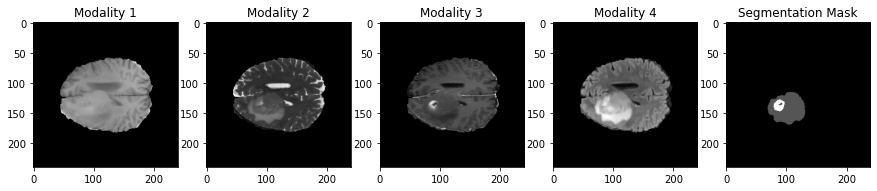

In [39]:
# Test the dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
dataset = BraTS2021Dataset(data_dir)

# Load a single patient's MRI scan and segmentation mask
patient_idx = 1
scan, mask = dataset[patient_idx]

# Print shape of scan and mask tensors
print('Scan tensor shape:', scan.shape)
print('Mask tensor shape:', mask.shape)

# Visualize the scan and mask using matplotlib
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(scan[i][:, :, 100], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[4].imshow(mask[:, :, 100], cmap='gray')
axs[4].set_title('Segmentation Mask')
plt.show()

In [40]:
import torch.utils.data

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
#Clean all memory unused
import gc

print(torch.cuda.memory_summary())

torch.cuda.empty_cache()
gc.collect() #force garbage collection
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4910 MiB |   5304 MiB | 178965 MiB | 174054 MiB |
|       from large pool |   4901 MiB |   5287 MiB | 178751 MiB | 173849 MiB |
|       from small pool |      9 MiB |     29 MiB |    214 MiB |    204 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   4910 MiB |   5304 MiB | 178965 MiB | 174054 MiB |
|       from large pool |   4901 MiB |   5287 MiB | 178751 MiB |

In [42]:
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Current GPU memory usage: 294.24 MB


In [43]:
if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print('My GPU is correctly configured. GPU device name:', device)
else:
    print('No GPU available')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(4, 4).to(device)

My GPU is correctly configured. GPU device name: NVIDIA GeForce RTX 3080 Laptop GPU


In [44]:
"""from torch import Tensor
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)
"""

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Calculate Dice coefficient for each channel
        dice_coeffs = []
        for i in range(input.size(1)):
            input_flat = input[:, i].reshape(-1)
            target_flat = (target == i).float().reshape(-1)
            intersection = (input_flat * target_flat).sum()
            union = input_flat.sum() + target_flat.sum()
            dice_coef = (2*intersection + self.smooth) / (union + self.smooth)
            dice_coeffs.append(dice_coef)

        # Calculate Dice loss
        dice_loss = 1 - torch.mean(torch.stack(dice_coeffs))

        return dice_loss

In [52]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define hyperparameters
learning_rate = 0.005
num_epochs = 1

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

dice_loss = DiceLoss()


grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

# Load checkpoint ==============================
#checkpoint = torch.load('checkpoint.pth')

# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================

softmax = nn.Softmax(dim = 1)

model.train()

#lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


for epoch in range(num_epochs):
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        set_images = images.permute(4, 0, 1, 2, 3)[:, 0, :, :, :].cuda()  # [batch, 4, 240, 240, 155] => [155, 4, 240, 240]
        set_labels = labels.permute(3, 0, 1, 2)[:, 0, :, :].cuda() # [batch, 240, 240, 155] => [155, 240, 240]

        image_chunks = torch.chunk(set_images, chunks=5, dim=0)
        labels_chunks = torch.chunk(set_labels, chunks=5, dim=0)
        #print ("each image and mask", image_chunks[0].shape, labels_chunks[0].shape)

        for i in range(len(image_chunks)):
            mini_img = image_chunks[i].to(device) # [31, 4, 240, 240]
            mini_lbl = labels_chunks[i].to(device) # [31, 240, 240]
            #print ("each mini-batch and mini-mask", mini_img.shape, mini_lbl.shape)
            
            # Forward pass
            outputs = model(mini_img) # [31, 4, 240, 240] 4 indeces

            #outputs = softmax (outputs) #trying this maybe
            """fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(6,12))
            axs[0].imshow(mini_img.float()[5][0].cpu(), cma|p='gray')
            axs[1].imshow(mini_img.float()[5][1].cpu(), cmap='gray')
            axs[2].imshow(mini_img.float()[5][2].cpu(), cmap='gray')
            axs[3].imshow(mini_img.float()[5][3].cpu(), cmap='gray')
            axs[4].imshow(mini_lbl.float()[5].cpu(), cmap='gray')
            plt.show()"""

            #print(outputs.shape, mini_lbl.shape)

            loss = criterion(outputs, mini_lbl.long())
            #loss += dice_loss(outputs, mini_lbl.long())          

            #print(outputs.shape, mini_lbl.shape)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            """optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()"""
        
            running_loss += loss.item()
            #print(loss.item())
            #print(outputs.sum()) #WHY THEY ARE ALL THE SAME

            #Why gradient norms are the same and all equal 0.000????
            """for name, param in model.named_parameters():
                if param.grad is not None:
                    print('%s: grad_norm=%.4f' % (name, param.grad.norm()))"""
        
        #lr_scheduler.step(loss)        
        # switch off autograd
        print("running_loss", running_loss)
        running_loss = 0
        #print(outputs)
        if counter % 10 == 9:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            },  'checkpoint.pth')
            print("Successfully saved")

with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
    # loop over the validation set
    for (x, y) in test_loader:
        # send the input to the device
        (x, y) = (x.permute(4, 0, 1, 2, 3)[:, 0, :, :, :].to(device), 
                    y.permute(3, 0, 1, 2)[:, 0, :, :].to(device))
        image_chunks = torch.chunk(x, chunks=5, dim=0)
        labels_chunks = torch.chunk(y, chunks=5, dim=0)
        # make the predictions and calculate the validation loss
        for i in range(len(image_chunks)):
            mini_img = image_chunks[i].to(device)
            mini_lbl = labels_chunks[i].to(device)
            pred = model(mini_img)
            totalTestLoss += criterion(pred, mini_lbl.float())
        print(totalTestLoss)
        totalTestLoss = 0


        

# batch input ([31, 4, 240, 240]) ========= batch mask ([31, 240, 240])
# Output shape ([31, 4, 240, 240])

encoder1.enc1conv1.weight: grad_norm=0.0001
encoder1.enc1norm1.weight: grad_norm=0.0000
encoder1.enc1norm1.bias: grad_norm=0.0000
encoder1.enc1conv2.weight: grad_norm=0.0001
encoder1.enc1norm2.weight: grad_norm=0.0000
encoder1.enc1norm2.bias: grad_norm=0.0000
encoder2.enc2conv1.weight: grad_norm=0.0002
encoder2.enc2norm1.weight: grad_norm=0.0000
encoder2.enc2norm1.bias: grad_norm=0.0000
encoder2.enc2conv2.weight: grad_norm=0.0001
encoder2.enc2norm2.weight: grad_norm=0.0001
encoder2.enc2norm2.bias: grad_norm=0.0001
encoder3.enc3conv1.weight: grad_norm=0.0005
encoder3.enc3norm1.weight: grad_norm=0.0001
encoder3.enc3norm1.bias: grad_norm=0.0001
encoder3.enc3conv2.weight: grad_norm=0.0003
encoder3.enc3norm2.weight: grad_norm=0.0000
encoder3.enc3norm2.bias: grad_norm=0.0000
encoder4.enc4conv1.weight: grad_norm=0.0002
encoder4.enc4norm1.weight: grad_norm=0.0000
encoder4.enc4norm1.bias: grad_norm=0.0000
encoder4.enc4conv2.weight: grad_norm=0.0001
encoder4.enc4norm2.weight: grad_norm=0.0000
en

KeyboardInterrupt: 

In [46]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

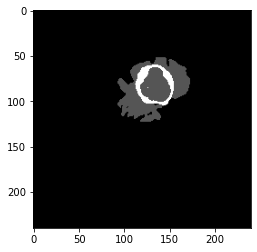

In [47]:
# Another test
mini_lbl.float().shape
plt.imshow(mini_lbl.float()[5].cpu(), cmap='gray')
plt.show()

In [48]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

each inp torch.Size([1, 4, 240, 240])
output shape torch.Size([4, 240, 240])


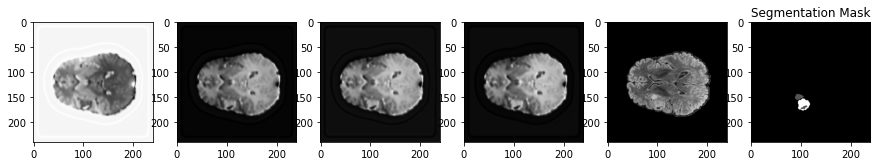

[[0.00015896 0.00048467 0.00045938 ... 0.00052357 0.00054045 0.00019908]
 [0.00045736 0.00056784 0.00044843 ... 0.00044385 0.0004902  0.00046304]
 [0.00039481 0.00043614 0.00038554 ... 0.00038399 0.00037726 0.0004146 ]
 ...
 [0.00041592 0.00041632 0.00036971 ... 0.0003675  0.00035955 0.00040997]
 [0.00054074 0.00059816 0.00045286 ... 0.00044166 0.00049449 0.00048492]
 [0.00017163 0.00051831 0.00046633 ... 0.00047857 0.00050576 0.00019843]]
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([4, 240, 240])


In [50]:
patient_idx = 20 # Test on random
scan, mask = dataset[patient_idx]
scan = scan.permute(3,0,1,2).cuda()
mask = mask.permute(2,0,1)

model.eval()

layer = 80

print ("each inp", scan[layer].unsqueeze(dim=0).shape)
with torch.no_grad():
    out = model(scan[layer].unsqueeze(dim=0))

out.cpu()
out = out[0, :, :, :]
print("output shape", out.shape)


############################
l1 = nn.Softmax(dim = 0)
#out = l1(out)
############################

fig, axs = plt.subplots(1, 6, figsize=(15, 5))
    
axs[0].imshow(out[0][:, :].cpu().detach().numpy(), cmap='gray')
axs[1].imshow(out[1][:, :].cpu().detach().numpy(), cmap='gray')
axs[2].imshow(out[2][:, :].cpu().detach().numpy(), cmap='gray')
axs[3].imshow(out[3][:, :].cpu().detach().numpy(), cmap='gray')

axs[4].imshow(scan[layer][3].cpu().detach().numpy(), cmap='gray') # second is modality
axs[5].imshow(mask[layer, :, :], cmap='gray')
axs[5].set_title('Segmentation Mask')
plt.show()
print (out[3][:, :].cpu().detach().numpy())
print (mask[layer, :, :])
print(out.shape)


In [30]:
print (out[2].sum())

tensor(10073.1602, device='cuda:0', grad_fn=<SumBackward0>)


In [13]:
# validation loop
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 251 test images: %d %%' % (
    100 * correct / total))
writer.add_scalar('validation accuracy', 100 * correct / total, epoch)

In [11]:
checkpoint = torch.load('checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

patient_idx = 1 # Test on random
scan, mask = dataset[patient_idx]
scan = scan.permute(3,0,1,2).cuda()
mask = mask.permute(2,0,1).cuda()
model(scan[0].unsqueeze(dim=0))

tensor([[[[1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742],
          [1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742],
          [1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742],
          ...,
          [1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742],
          [1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742],
          [1603.5742, 1603.5742, 1603.5742,  ..., 1603.5742, 1603.5742,
           1603.5742]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)

torch.Size([4, 240, 240])


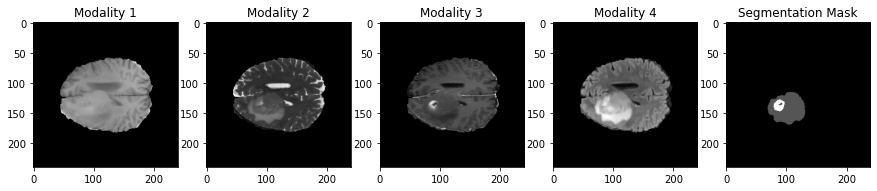

In [30]:
patient_idx = 1 # Test on random
scan, mask = dataset[patient_idx]

# Load single image
testttt = scan

# Convert input tensor to same data type as model parameters
testttt = testttt.type(model.parameters().__next__().dtype)
scan = scan[:,:,:,100]
print (scan.shape)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(scan[i][:, :], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[4].imshow(mask[:, :, 100], cmap='gray')
axs[4].set_title('Segmentation Mask')
plt.show()

In [51]:
scan = scan.cuda()
picpic = model (scan.unsqueeze(dim=0)).cpu()
picpic.shape

torch.Size([1, 1, 240, 240])

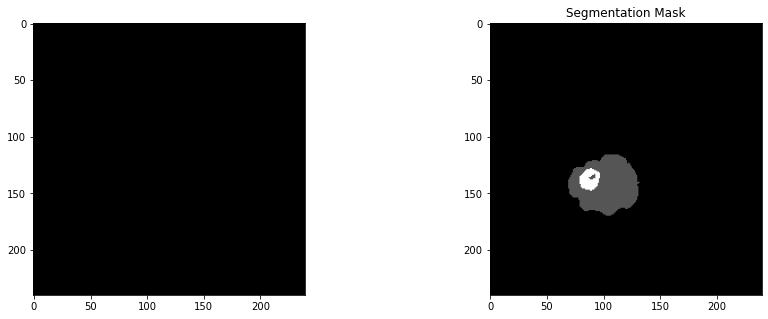

[[[[1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]
   [1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]
   [1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]
   ...
   [1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]
   [1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]
   [1603.5742 1603.5742 1603.5742 ... 1603.5742 1603.5742 1603.5742]]]]
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [52]:
picpic = picpic.detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(picpic[0][0][:, :], cmap='gray')
axs[1].imshow(mask[:, :, 100], cmap='gray')
axs[1].set_title('Segmentation Mask')
plt.show()
print (picpic)
print (mask[:, :, 100])

In [59]:
test1 = picpic[0, 0, :, :]
test1[100, 210]

1603.5742

In [62]:
mask[140, 90, 100]

tensor(3)

In [66]:
m = nn.Softmax(dim=1)
kk = torch.randn(2, 3)
aa = m(kk)
aa

tensor([[0.4366, 0.2634, 0.3000],
        [0.7727, 0.1452, 0.0820]])